In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl

In [2]:
data=pd.read_csv('newest.csv')
data = data.replace("Checked", "Yes")
data = data.replace("Unchecked", "No")

data.loc[data['Was sludge seen in the common bile duct on EUS?'] == 'Yes', 'Was a common bile duct stone (choledocholithiasis) seen on EUS?'] = 'Yes' # Was sludge seen in the common bile duct on EUS? assumed to be treated as stone
data.loc[data['Was sludge seen in the common bile duct on ERCP?'] == 'Yes', 'Was a stone present on ERCP?'] = 'Yes'
data.loc[data['Was common bile duct SLUDGE found on imaging? Check appropriate box if found on ultrasound, CT scan, and/or MRI/MRCP (choice=MRI/MRCP)'] == 'Yes', 'Was a bile duct stone (choledocholithiasis) found on imaging? Check appropriate box if found on ultrasound, CT scan, and/or MRI/MRCP (choice=MRI/MRCP)'] = 'Yes'

data['Urine bilirubin, qualitative  *This is part of standard urinalysis  *If multiple values exist please use first instance during the presentation'] = data['Urine bilirubin, qualitative  *This is part of standard urinalysis  *If multiple values exist please use first instance during the presentation'].apply(lambda x: 'No' if x == 'Negative' else ('Yes' if pd.notna(x) else np.nan))


data.loc[data['Was common bile duct SLUDGE found on imaging? Check appropriate box if found on ultrasound, CT scan, and/or MRI/MRCP (choice=CT scan)']=='Yes','Was a bile duct stone (choledocholithiasis) found on imaging? Check appropriate box if found on ultrasound, CT scan, and/or MRI/MRCP (choice=CT scan)']='Yes'

data.loc[data['Was common bile duct SLUDGE found on imaging? Check appropriate box if found on ultrasound, CT scan, and/or MRI/MRCP (choice=Ultrasound)']=='Yes','Was a bile duct stone (choledocholithiasis) found on imaging? Check appropriate box if found on ultrasound, CT scan, and/or MRI/MRCP (choice=Ultrasound)']='Yes'

### Grouping lab values until 24 hr

In [3]:
# Prepare new columns for AST, ALT, Alkaline Phosphatase, and Total Bilirubin
new_columns = {
    'AST <24 hr after presentation': data.iloc[:, 45].fillna(data.iloc[:, 41]).fillna(data.iloc[:, 37]),
    'ALT <24 hr after presentation': data.iloc[:, 46].fillna(data.iloc[:, 42]).fillna(data.iloc[:, 38]),
    'Alkaline phosphatase <24 hr after presentation': data.iloc[:, 47].fillna(data.iloc[:, 43]).fillna(data.iloc[:, 39]),
    'Total bilirubin <24 hr after presentation': data.iloc[:, 48].fillna(data.iloc[:, 44]).fillna(data.iloc[:, 40]),
}

# Add the new columns in a single operation
data = pd.concat([data, pd.DataFrame(new_columns)], axis=1)

In [4]:
#checking the values in gender column
invalid_indices = data[~data['Gender'].isin(['Male', 'Female'])].index
print('Subjects with no gender values specified',invalid_indices.tolist())
data=data.drop(invalid_indices)

# Specifying the labele column
data.rename(columns={"Does the patient have choledocholithiasis (stone OR sludge in the common bile duct)?    A few notes:     1. Mark yes if they have a common bile duct stone on ERCP, MRCP, CT scan, or intra-operative cholangiogram.   2. Also mark yes if there is concern that the patient had choledocholithiasis but that there is a past stone      examples include but are not limited to:            a. pancreatitis + transamanitis - concern for gallstone (aka biliary) pancreatitis without finding of stone on imaging/ERCP           b. gallbladder stones (cholelithiasis) + transaminitis + RUQ pain without stone on imaging/ERCP (likely passed stone)  3. Also mark yes if they have cholangitis secondary to choledocholithiasis.": 'Label'}, inplace=True)
print("Data size",data.shape)

## We consider sludge as a stone
data.drop(columns='Was sludge seen in the common bile duct on ERCP?',inplace=True) 
data.drop(columns='Was sludge seen in the common bile duct on EUS?',inplace=True)
data.drop(columns='Was common bile duct SLUDGE found on imaging? Check appropriate box if found on ultrasound, CT scan, and/or MRI/MRCP (choice=MRI/MRCP)',inplace=True)

Subjects with no gender values specified [332, 1556]
Data size (2383, 204)


### Generating the age column 

In [5]:
age_difference = (pd.to_datetime(data['Date of first presentation to hospital.     We want to know the date of hospital presentation for patients with initial presentation of choledocholithiasis or choledocholithiasis-driven cholangitis.  ']) - pd.to_datetime(data['Date of birth'])).dt.days / 365
age_difference = age_difference.fillna(0).astype(int)
# data[data.columns[56]] = pd.to_datetime(data[data.columns[56]], errors='coerce')
# ultrasound_age = (data[data.columns[56]]-data[data.columns[7]]).dt.days

# Replace only non-NaN values with integer values and keep NaN as is
age_difference = age_difference.where(age_difference != 0, None)
data['Age (at time of initial presentation)']=age_difference

data['Age (at time of initial presentation)']
invalid_indices = data[
    data['Age (at time of initial presentation)'].isna() | 
    (data['Age (at time of initial presentation)'] < 0)
].index

data.loc[
    data['Age (at time of initial presentation)'].isna() | 
    (data['Age (at time of initial presentation)'] < 0),
    'Age (at time of initial presentation)'
]

data=data.drop(invalid_indices)
print('Number of subjects with invalid age:',len(invalid_indices.tolist()))

Number of subjects with invalid age: 41


### Calculating the Total point score following [CCI](https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci) guidelines

In [6]:
weights={'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=Myocardial infarct (+1))':1,
         'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=Congestive heart failure (+1))':1,
         'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=Peripheral vascular disease (+1))':1,
         'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=Cerebrovascular disease (except hemiplegia) (+1))':1,
         'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=Dementia (+1))':1,
         'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=Chronic pulmonary disease (+1))':1,
         'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=Connective tissue disease (+1))':1,
         'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=Ulcer disease (+1))':1,
         'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=Mild liver disease (+1))':1,
         'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=Diabetes (without complications) (+1))':1,
         'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=Diabetes with end organ damage (+2))':2,
         'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=Hemiplegia (+2))':2,
         'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=Moderate or severe renal disease (+2))':2,
         'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=Solid tumor (non metastatic) (+2))':2,
         'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=Leukemia (+2))':2,
         'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=Lymphoma, Multiple myeloma (+2))':2,
         'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=Moderate or severe liver disease (+3))':3,
         'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=Metastatic solid tumor (+6))':6,
         'Comorbidity (Choose all that are present)    Assigned weights for each condition the patient has ( )    More specific definitions are here: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci   (choice=AIDS (+6))':6}

for col, weight in weights.items():
    data[col] = data[col].apply(lambda x: weight if x == "Yes" else 0)
def age_weight(age):
    if age < 50:
        return 0
    elif 50 <= age < 60:
        return 1
    elif 60 <= age < 70:
        return 2
    elif 70 <= age < 80:
        return 3
    else:
        return 4
    
data['age_weight'] = data['Age (at time of initial presentation)'].apply(age_weight)
data['Total points:']=data[list(weights.keys())].sum(axis=1)+data["age_weight"]

### Histogram of age for the patients

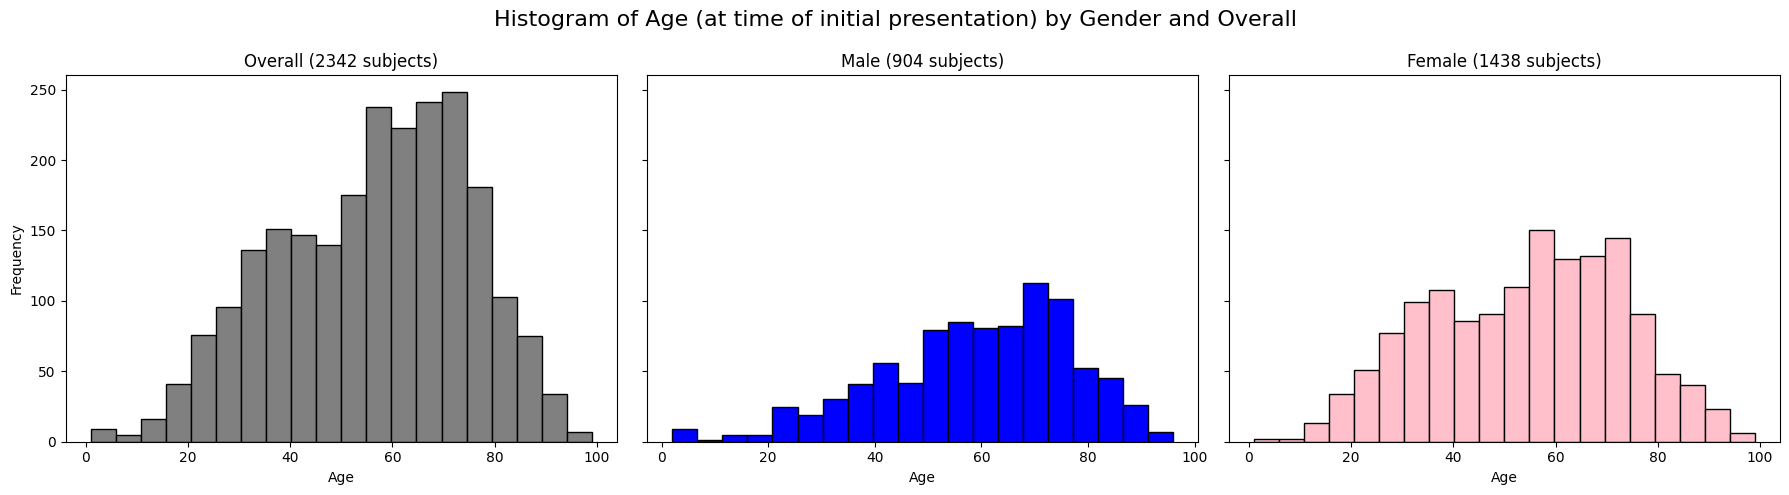

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Overall histogram
axes[0].hist(data['Age (at time of initial presentation)'], bins=20, edgecolor='black', color='gray')
axes[0].set_title(f'Overall ({data.shape[0]} subjects)')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Male histogram
axes[1].hist(data[data['Gender'] == 'Male']['Age (at time of initial presentation)'], bins=20, edgecolor='black', color='blue')
m_num=data[data['Gender'] == 'Male'].shape[0]
axes[1].set_title(f'Male ({m_num} subjects)')
axes[1].set_xlabel('Age')

# Female histogram
axes[2].hist(data[data['Gender'] == 'Female']['Age (at time of initial presentation)'], bins=20, edgecolor='black', color='pink')
f_num=data[data['Gender'] =='Female'].shape[0]
axes[2].set_title(f'Female ({f_num} subjects)')
axes[2].set_xlabel('Age')

# Set a common title for all subplots
fig.suptitle('Histogram of Age (at time of initial presentation) by Gender and Overall', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust layout to fit the suptitle
plt.show()

### Check the colored columns

In [8]:
# Load the workbook and the specific worksheet
file_path = "Features_list.xlsx"
wb = openpyxl.load_workbook(file_path, data_only=True)
ws = wb.active  # or specify sheet name ws = wb["SheetName"]

# Set to store colored column names
colored_columns = []
chosen_feaures_label = []

# Loop through columns to find colored ones
for col in ws.iter_cols():
    for cell in col:
        if cell.fill.start_color.index != '00000000':  # Checks if the cell is colored
            colored_columns.append(cell.column_letter)
            chosen_feaures_label.append(col[0].value)
            break  # No need to check further cells in this column if one is colored
chosen_feaures_label[1]='Label'
chosen_feaures_label.append('Age (at time of initial presentation)')
chosen_feaures_label.append('AST <24 hr after presentation')
chosen_feaures_label.append('ALT <24 hr after presentation')
chosen_feaures_label.append('Alkaline phosphatase <24 hr after presentation')
chosen_feaures_label.append('Total bilirubin <24 hr after presentation')
print('Number of features:',len(chosen_feaures_label))

Number of features: 27


### Labeling the yes/no columns with 1/0 while keeoing NaN values as it is

In [9]:
new_df = data[chosen_feaures_label]
# 0-1 encoding for gender
new_df= new_df.replace({'Female': 0, 'Male': 1})
# 0-1 encoding for all the yes and no columns
new_df=new_df.replace({'Yes': 1, 'No': 0})
# new_df=new_df.replace({'Unchecked': 0, 'Checked': 1})
# new_df=new_df.apply(lambda x: 1 if x.astype(str).str.contains(r'\S').any() else 0, axis=1)
# new_df

### Check the type of data in columns?

In [10]:
non_numeric_columns = new_df.select_dtypes(exclude='number')

# Check if there are any non-numeric columns
if not non_numeric_columns.empty:
    check_list=non_numeric_columns.columns.tolist()
    print("There are non-numerical columns in the DataFrame:")
    print(check_list)
else:
    print("All columns are numerical.")

All columns are numerical.


### Drop the columns that have any missing values

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.inspection import permutation_importance

# Assuming df is your data frame and 'label' is the column for the labels
# Replace 'label' with the name of the label column in your data frame
no_nan_df = new_df.dropna(axis=1)
print('Shape of the data:',no_nan_df.shape)
X = no_nan_df.drop('Label',axis=1)
y = no_nan_df['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on training and testing data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Get the predicted probabilities for the training and testing data
y_train_proba = rf.predict_proba(X_train)
y_test_proba = rf.predict_proba(X_test)

# Calculate accuracy on training and testing data
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

Shape of the data: (2342, 6)
Training Accuracy: 0.75
Testing Accuracy: 0.66


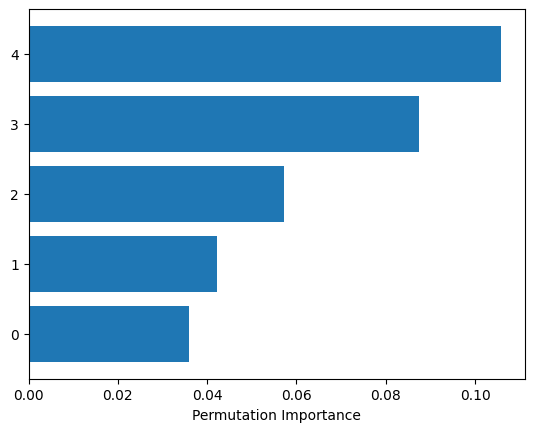

,Importance
Age (at time of initial presentation),0.509487
"Was a bile duct stone (choledocholithiasis) found on imaging? Check appropriate box if found on ultrasound, CT scan, and/or MRI/MRCP (choice=CT scan)",0.210682
"Was a bile duct stone (choledocholithiasis) found on imaging? Check appropriate box if found on ultrasound, CT scan, and/or MRI/MRCP (choice=Ultrasound)",0.154600
Total points:,0.105244
Gender,0.019986


In [12]:
result = permutation_importance(rf, X, y, n_repeats=10, random_state=42)

# Plot permutation importance
sorted_idx = result.importances_mean.argsort()
plt.barh(range(X.shape[1]), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(X.shape[1]), sorted_idx)
plt.xlabel("Permutation Importance")
plt.show()

pd.DataFrame(rf.feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

### The features with NaN 

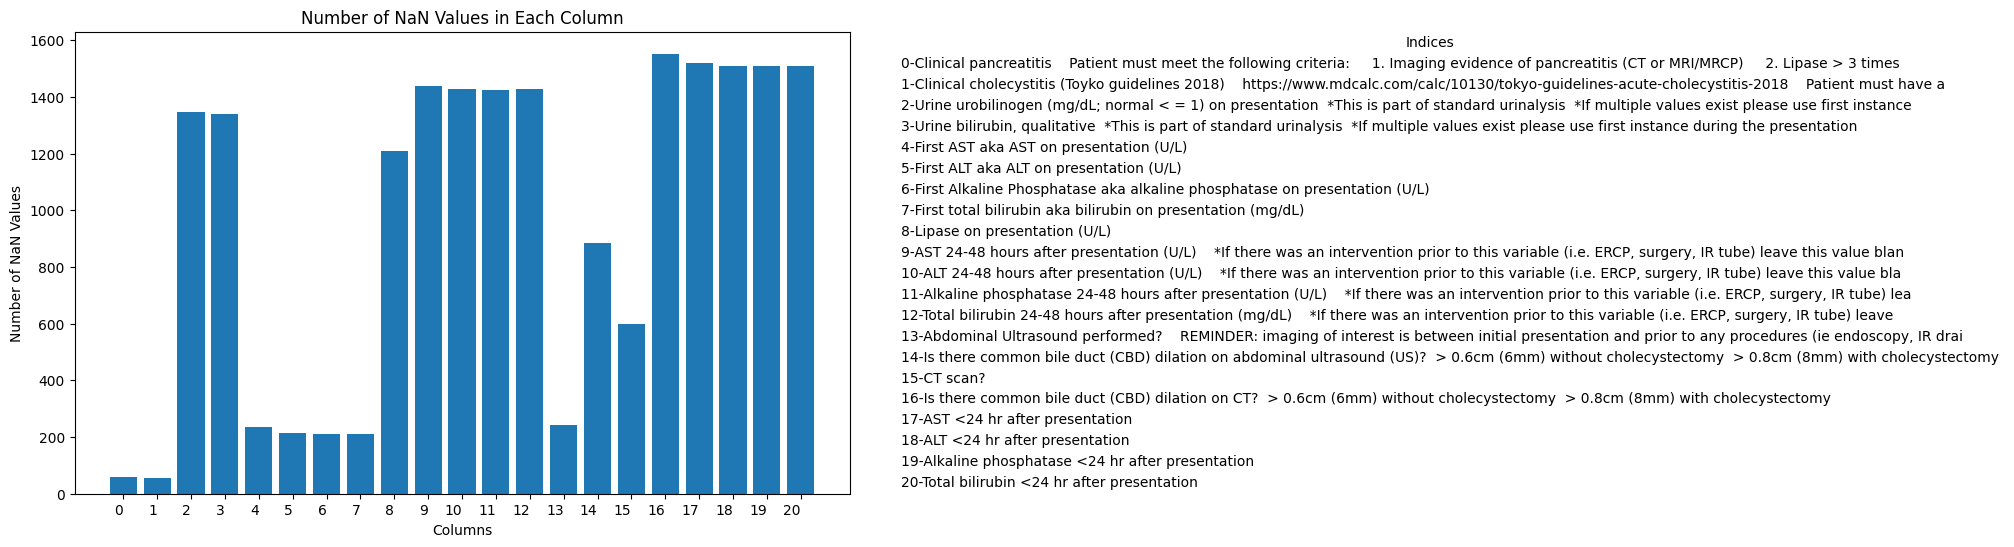

In [13]:
nan_counts = new_df.isna().sum()

nan_counts_filtered = nan_counts[nan_counts > 0]

# Plot the number of NaN values for each column
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(np.arange(len(nan_counts_filtered.index)), nan_counts_filtered.values)
handles = [plt.Line2D([0], [0], color='none', marker='s', markersize=10, label=f'{_}-{index}'.ljust(100)[:150]) for _ , index in enumerate(nan_counts_filtered.index)]
ax.legend(handles=handles, title='Indices', loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.xticks(np.arange(len(nan_counts_filtered.index)), ha='right')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.title('Number of NaN Values in Each Column')
plt.show()

### Drop the features that have more than 500 missing values

In [14]:
from sklearn.model_selection import cross_val_score
nan_counts = new_df.isna().sum()
nan_counts_filtered_500 = nan_counts[nan_counts > 500]

no_nan_df = new_df.drop(columns=nan_counts_filtered_500.index)
no_nan_df = no_nan_df.dropna(axis=0) # Drop rows with missing values in any column
print('size of data after dropping columns with more than 500 missing values:',no_nan_df.shape)
X = no_nan_df.drop('Label',axis=1)
y = no_nan_df['Label']

seed=42
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

# Create and train the Random Forest model
rf = RandomForestClassifier(n_estimators=10,min_samples_leaf=3,random_state=seed,max_depth=200) # oob_score=True,
rf.fit(X_train, y_train)

# Predict on training and testing data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate accuracy on training and testing data
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
# cv_scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")
# print("Cross-validation scores for each fold:", cv_scores)
# print("Average cross-validation accuracy:", cv_scores.mean())

size of data after dropping columns with more than 500 missing values: (1894, 13)
Training Accuracy: 0.92
Testing Accuracy: 0.83


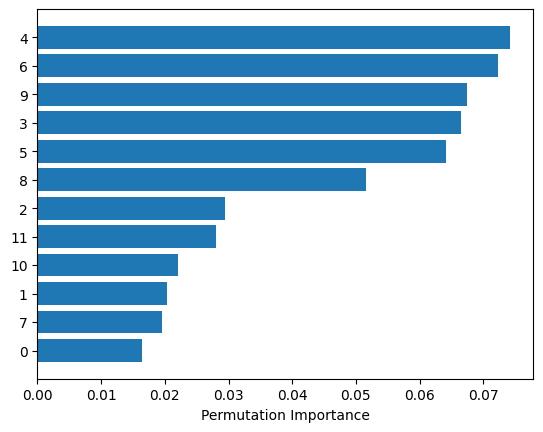

,Importance
First ALT aka ALT on presentation (U/L),0.197286
First Alkaline Phosphatase aka alkaline phosphatase on presentation (U/L),0.160101
First AST aka AST on presentation (U/L),0.145963
First total bilirubin aka bilirubin on presentation (mg/dL),0.137390
"Was a bile duct stone (choledocholithiasis) found on imaging? Check appropriate box if found on ultrasound, CT scan, and/or MRI/MRCP (choice=CT scan)",0.094835
"Was a bile duct stone (choledocholithiasis) found on imaging? Check appropriate box if found on ultrasound, CT scan, and/or MRI/MRCP (choice=Ultrasound)",0.079132
Age (at time of initial presentation),0.062492
"Clinical cholecystitis (Toyko guidelines 2018) https://www.mdcalc.com/calc/10130/tokyo-guidelines-acute-cholecystitis-2018 Patient must have a suspected diagnosis (≥1 item in A + ≥1 item in B or C) or definite diagnosis (≥1 item in A, B, and C) to meet entry criteria for severity grading, see table below: Part A (Local signs of inflammation) 1. Murphy's sign 2. Right upper abdominal quadrant mass, pain, or tenderness Part B (Systemic signs of inflammation) 1. Fever 2. Elevated CRP 3. Elevated WBC count Part C (Imaging) 1. Imaging findings characteristic of acute cholecystitis *e.g. pericholecystic fluid, gallstones/debris. Cited from Yokoe et al. [7]. Acute hepatitis, other acute abdominal diseases, and chronic cholecystitis should be excluded CRP C-reactive protein, RUQ right upper abdominal quadrant, WBC white blood cell",0.033986
Clinical pancreatitis Patient must meet the following criteria: 1. Imaging evidence of pancreatitis (CT or MRI/MRCP) 2. Lipase > 3 times upper limit of normal 3. Characteristic abdominal pain,0.032916
Total points:,0.024036


In [15]:
result = permutation_importance(rf, X, y, n_repeats=10, random_state=42)

# Plot permutation importance
sorted_idx = result.importances_mean.argsort()
plt.barh(range(X.shape[1]), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(X.shape[1]), sorted_idx)
plt.xlabel("Permutation Importance")
plt.show()

pd.DataFrame(rf.feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

### Logistic regression on most important features

In [16]:
from sklearn.linear_model import LogisticRegression


# Get feature importances from the Random Forest model
importances = rf.feature_importances_

# Sort features by importance and get indices of top 5
indices = np.argsort(importances)[::-1][:5]

top_5_features = X_train.columns[indices]
X_train_top5 = X_train[top_5_features]
X_test_top5 = X_test[top_5_features]

regressor = LogisticRegression()
regressor.fit(X_train_top5, y_train)


y_train_pred = regressor.predict(X_train_top5)
y_test_pred = regressor.predict(X_test_top5)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")
no_nan_df.shape

Training Accuracy: 0.73
Testing Accuracy: 0.74


(1894, 13)

# RF with imputation KNN

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

data_df = new_df
X = data_df.drop('Label',axis=1)
y = data_df['Label']

seed=42
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)



# Imputation step with KNN
pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),  # or use KNNImputer() for more complex patterns
    ('model', RandomForestClassifier(n_estimators=20,random_state=42))
])


# Fit the model
pipeline.fit(X_train, y_train)

train_predictions = pipeline.predict(X_train)
test_predictions = pipeline.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

test_precision = precision_score(y_test, test_predictions, average='binary')  # For binary classification
test_recall = recall_score(y_test, test_predictions, average='binary')

print(f"Test Precision: {test_precision:.2f}")
print(f"Test Sensitivity (Recall): {test_recall:.2f}")

Training Accuracy: 1.00
Test Accuracy: 0.80
Test Precision: 0.81
Test Sensitivity (Recall): 0.76


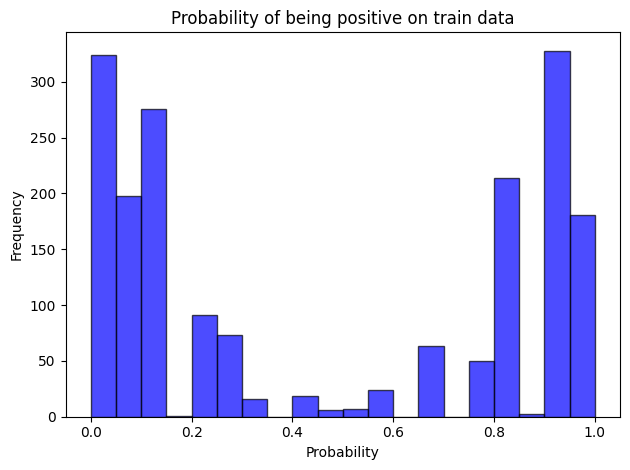

In [18]:
hist_column= pipeline.predict_proba(X_train)
def plot_histogram(hist_column, x: str):
    # Create the figure and axis
    # plt.figure(figsize=(8, 6))
    # Plot the histogram for the first column (negative probabilities)
    plt.hist(hist_column[:, 1], bins=20, edgecolor='black', color='blue', alpha=0.7)
    
    # Add titles and labels
    plt.title(f'Probability of being positive on {x} data')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    
    # Display the histogram
    plt.tight_layout()
    plt.show()

plot_histogram(hist_column, 'train')

# GBM without indicator

Training Accuracy: 0.85
Test Accuracy: 0.81
Test Precision: 0.83
Test Sensitivity (Recall): 0.75


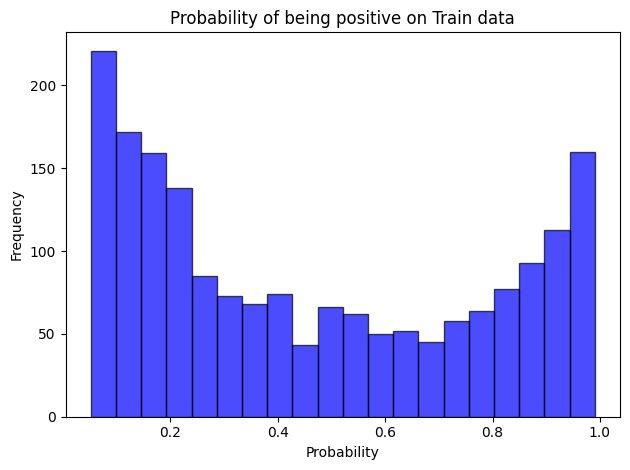

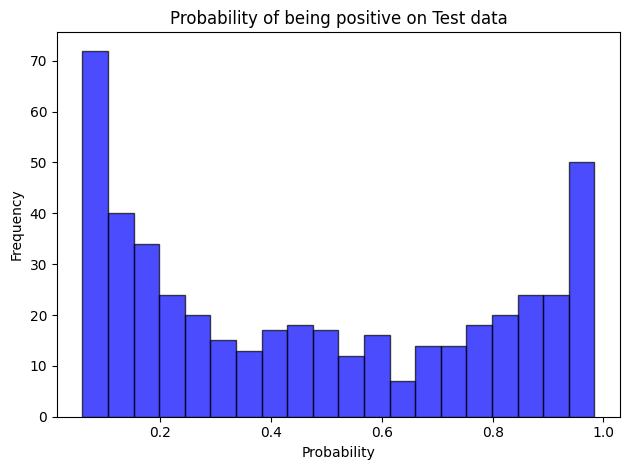

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
data_df = new_df
X = data_df.drop('Label',axis=1)
y = data_df['Label']


knn_imputer = KNNImputer(n_neighbors=5)  # Set the number of neighbors
X_imputed = knn_imputer.fit_transform(X)
seed=42
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=seed)

# Initialize the model
model = GradientBoostingClassifier(n_estimators=60, learning_rate=0.1, random_state=seed)

# Fit the model
model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)


train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

test_precision = precision_score(y_test, test_predictions, average='binary')  # For binary classification
test_recall = recall_score(y_test, test_predictions, average='binary')

print(f"Test Precision: {test_precision:.2f}")
print(f"Test Sensitivity (Recall): {test_recall:.2f}")

hist_column= model.predict_proba(X_train)
plot_histogram(hist_column, 'Train')

hist_column= model.predict_proba(X_test)
plot_histogram(hist_column, 'Test')

# GBM with indicator

Training Accuracy: 0.89
Test Accuracy: 0.86
Test Precision: 0.85
Test Sensitivity (Recall): 0.85


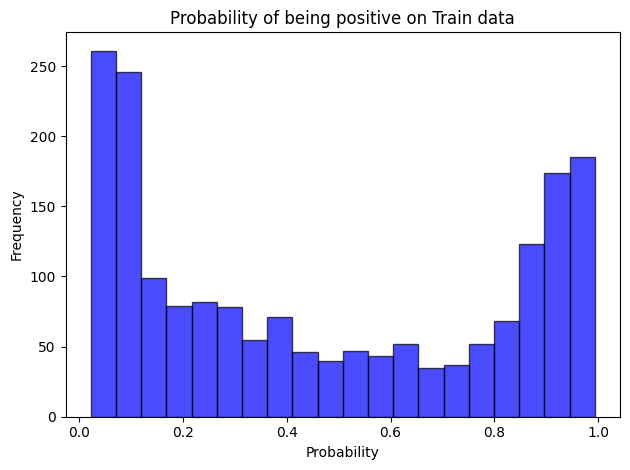

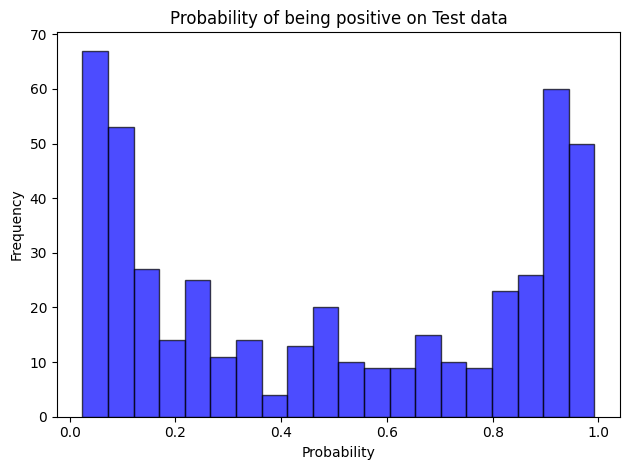

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
data_df = new_df.copy()
X = data_df.drop('Label',axis=1)
y = data_df['Label']

for col in X.columns:
    # Check if the column has missing values
    # if X[col].isnull().any():
        # Create a new indicator column with 1 for missing values and 0 otherwise
        X[f'{col}_missing_indicator'] = X[col].isnull().astype(int)
        
knn_imputer = KNNImputer(n_neighbors=5)  # Set the number of neighbors
X_imputed = knn_imputer.fit_transform(X)
seed=42
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=seed)

# Initialize the model
model = GradientBoostingClassifier(n_estimators=60, learning_rate=0.1, random_state=seed)

# Fit the model
model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)


train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

test_precision = precision_score(y_test, test_predictions, average='binary')  # For binary classification
test_recall = recall_score(y_test, test_predictions, average='binary')

print(f"Test Precision: {test_precision:.2f}")
print(f"Test Sensitivity (Recall): {test_recall:.2f}")

hist_column= model.predict_proba(X_train)
plot_histogram(hist_column, 'Train')

hist_column= model.predict_proba(X_test)
plot_histogram(hist_column, 'Test')

# Model Ensemble or Stacking Approach without indicator

Training Accuracy: 0.94
Test Accuracy: 0.86
Test Precision: 0.85
Test Sensitivity (Recall): 0.86


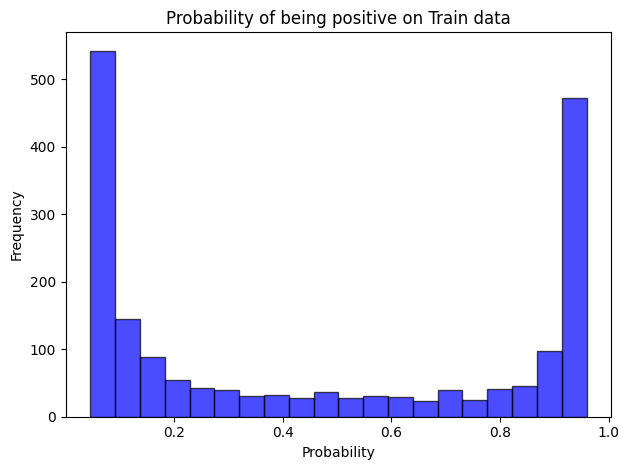

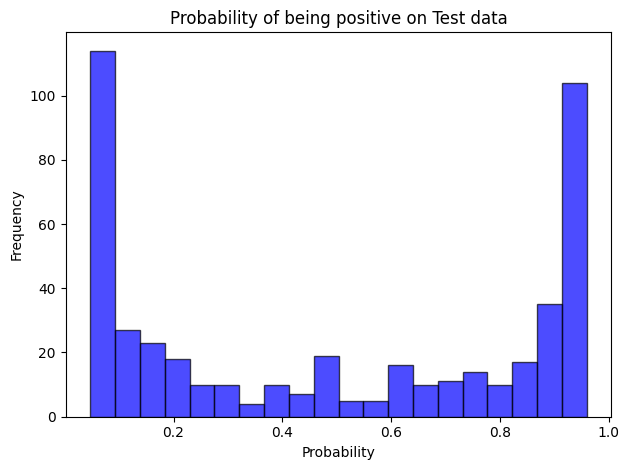

In [21]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

data_df = new_df
X = data_df.drop('Label',axis=1)
y = data_df['Label']

seed=42
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
rf_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

gb_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

svc_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('svc', SVC(probability=True, random_state=42))
])

# Define the stacking ensemble
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_pipeline),
        ('gb', gb_pipeline),
        ('svc', svc_pipeline)
    ],
    final_estimator=LogisticRegression(),  # Meta-model
    cv=5
)

# Train the stacking model
stacking_clf.fit(X_train, y_train)

train_predictions = stacking_clf.predict(X_train)
test_predictions = stacking_clf.predict(X_test)

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")


test_precision = precision_score(y_test, test_predictions, average='binary')  # For binary classification
test_recall = recall_score(y_test, test_predictions, average='binary')

print(f"Test Precision: {test_precision:.2f}")
print(f"Test Sensitivity (Recall): {test_recall:.2f}")

hist_column= stacking_clf.predict_proba(X_train)
plot_histogram(hist_column, 'Train')

hist_column= stacking_clf.predict_proba(X_test)
plot_histogram(hist_column, 'Test')

Training Accuracy: 0.96
Test Accuracy: 0.87
Test Precision: 0.86
Test Sensitivity (Recall): 0.87


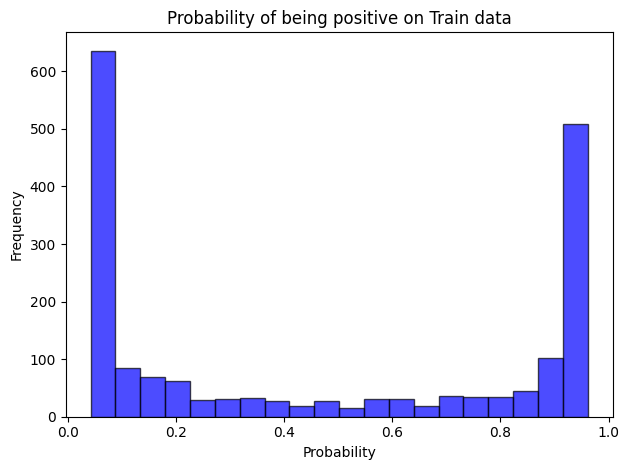

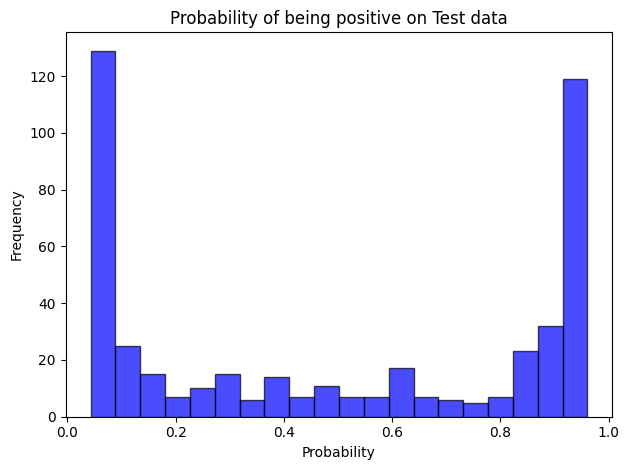

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

data_df = new_df
X = data_df.drop('Label',axis=1)
y = data_df['Label']

for col in X.columns:
    # Check if the column has missing values
    if X[col].isnull().any():
        # Create a new indicator column with 1 for missing values and 0 otherwise
        X[f'{col}_missing_indicator'] = X[col].isnull().astype(int)


seed=42
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
rf_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

gb_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

svc_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('svc', SVC(probability=True, random_state=42))
])

# Define the stacking ensemble
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_pipeline),
        ('gb', gb_pipeline),
        ('svc', svc_pipeline)
    ],
    final_estimator=LogisticRegression(),  # Meta-model
    cv=5
)

# Train the stacking model
stacking_clf.fit(X_train, y_train)

train_predictions = stacking_clf.predict(X_train)
test_predictions = stacking_clf.predict(X_test)

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")


test_precision = precision_score(y_test, test_predictions, average='binary')  # For binary classification
test_recall = recall_score(y_test, test_predictions, average='binary')

print(f"Test Precision: {test_precision:.2f}")
print(f"Test Sensitivity (Recall): {test_recall:.2f}")

hist_column= stacking_clf.predict_proba(X_train)
plot_histogram(hist_column, 'Train')

hist_column= stacking_clf.predict_proba(X_test)
plot_histogram(hist_column, 'Test')

### Adding the procedures as features and training the model 

In [ ]:
df_opt=data.copy()

file_path = "./Second part/Features_2.xlsx"
wb = openpyxl.load_workbook(file_path, data_only=True)
ws = wb.active  # or specify sheet name ws = wb["SheetName"]

# Set to store colored column names
colored_columns = []
chosen_features_label_opt = []

# Loop through columns to find colored ones
for col in ws.iter_cols():
    for cell in col:
        if cell.fill.start_color.index != '00000000':  # Checks if the cell is colored
            colored_columns.append(cell.column_letter)
            chosen_features_label_opt.append(col[0].value)
            break  # No need to check further cells in this column if one is colored

chosen_features_label_opt

['MRI/MRCP?',
 'Is there common bile duct (CBD) dilation on MRI/MRCP?  > 0.6cm (6mm) without cholecystectomy  > 0.8cm (8mm) with cholecystectomy',
 'Was a bile duct stone (choledocholithiasis) found on imaging? Check appropriate box if found on ultrasound, CT scan, and/or MRI/MRCP (choice=MRI/MRCP)',
 'Was EUS performed?',
 'Was a common bile duct stone (choledocholithiasis) seen on EUS?',
 'Was ERCP performed?',
 'Was a stone present on ERCP?',
 'Was intra-operative cholangiogram performed during cholecystectomy?',
 'Did intra-operative cholangiogram show a stone?']

### Calculating specificity, precision, sensitivity, and accuracy for each procedure 

In [24]:
def se_sp(data,procedure):
    temp=data[data[procedure[0]]=='Yes'].copy()
    # temp.fillna('No',inplace=True)
    temp[procedure[1]]=temp[procedure[1]].fillna('No')
    # True Positive (TP)
    tp=temp[(temp[procedure[1]]=='Yes') & (temp['Label']=='Yes')].shape[0]
    # False Negative (FN)
    fn = temp[(temp[procedure[1]] == 'No') & (temp['Label'] == 'Yes')].shape[0]
    # True Negative (TN)
    tn = temp[(temp[procedure[1]] == 'No') & (temp['Label'] == 'No')].shape[0]
    # False Positive (FP)
    fp = temp[(temp[procedure[1]] == 'Yes') & (temp['Label'] == 'No')].shape[0]
    
    # Specificity
    specificity = tn / (tn + fp)

    # Precision
    precision = tp / (tp + fp)

    # Sensitivity (Recall)
    sensitivity = tp / (tp + fn)

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    # print(f'Specificity, precision, sensitivity, accuracy:')
    numbers=[specificity, precision, sensitivity,accuracy]
    numbers = [0.999 if x == 1 else x for x in numbers]
    return [round(num, 3) for num in numbers]

print(se_sp(data,['MRI/MRCP?','Was a bile duct stone (choledocholithiasis) found on imaging? Check appropriate box if found on ultrasound, CT scan, and/or MRI/MRCP (choice=MRI/MRCP)']))

print(se_sp(data,['Was EUS performed?','Was a common bile duct stone (choledocholithiasis) seen on EUS?']))

print(se_sp(data,['Was ERCP performed?','Was a stone present on ERCP?']))

print(se_sp(data,['Was intra-operative cholangiogram performed during cholecystectomy?','Did intra-operative cholangiogram show a stone?']))

[0.999, 0.999, 0.635, 0.725]
[0.986, 0.976, 0.641, 0.825]
[0.995, 0.999, 0.869, 0.89]
[0.999, 0.999, 0.387, 0.78]


### Diagnostic likelihood ratio for each procedure

In [25]:
def bayesian_update(prior_prob, sensitivity, specificity, result):
    if result == 1:
        likelihood_ratio = sensitivity / (1 - specificity+1e-8)
    elif result == 0:
        likelihood_ratio = (1 - sensitivity) / specificity
    else:
        return prior_prob  # If result is inconclusive, return prior

    prior_odds = prior_prob / (1 - prior_prob)
    posterior_odds = prior_odds * likelihood_ratio
    posterior_prob = posterior_odds / (1 + posterior_odds)
    return posterior_prob

## Example
prior_prob=model.predict_proba([X_imputed[3]])[0][1]
tests_we_want=['MRI/MRCP?','Was a bile duct stone (choledocholithiasis) found on imaging? Check appropriate box if found on ultrasound, CT scan, and/or MRI/MRCP (choice=MRI/MRCP)']
se=se_sp(data,tests_we_want)[2]
sp=se_sp(data,tests_we_want)[0]

print('Prior probability of having stone:',prior_prob)
print('Updated probability:',bayesian_update(prior_prob,se,sp,1))

Prior probability of having stone: 0.825856216242913
Updated probability: 0.9996680367878213


In [26]:
from sklearn.model_selection import cross_val_score


scores = cross_val_score(model, X_imputed, y, cv=10, scoring='accuracy')

# Print the scores for each fold and the mean accuracy
print("Cross-validation scores for each fold:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores for each fold: [0.76170213 0.85531915 0.75641026 0.91025641 0.8974359  0.81196581
 0.87179487 0.85042735 0.82905983 0.78632479]
Mean accuracy: 0.8330696490270958


## Prediction models for MRCP, EUS, ERCP and IOC procedures

### MRCP

In [28]:
proce=chosen_features_label_opt[2]
comp_features=chosen_feaures_label+[proce]
new_df = data[comp_features]
# 0-1 encoding for gender
new_df= new_df.replace({'Female': 0, 'Male': 1})
# 0-1 encoding for all the yes and no columns
new_df=new_df.replace({'Yes': 1, 'No': 0})


data_df=new_df.copy()
data_df=data_df.drop('Label',axis=1)
data_df=data_df.dropna(subset=[proce])
X = data_df.drop(proce,axis=1)
y = data_df[proce]

for col in X.columns:
        # Create a new indicator column with 1 for missing values and 0 otherwise
        X[f'{col}_missing_indicator'] = X[col].isnull().astype(int)

seed=42

knn_imputer = KNNImputer(n_neighbors=5)  # Set the number of neighbors
X_imputed = knn_imputer.fit_transform(X)
seed=42
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=seed)

# Initialize the model_mrcp
model_mrcp = GradientBoostingClassifier(n_estimators=60, learning_rate=0.1, random_state=seed)

# Fit the model
model_mrcp.fit(X_train, y_train)

train_predictions = model_mrcp.predict(X_train)
test_predictions = model_mrcp.predict(X_test)
train_prob=model_mrcp.predict_proba(X_train)
test_prob=model_mrcp.predict_proba(X_test)



train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

test_precision = precision_score(y_test, test_predictions, average='binary')  # For binary classification
test_recall = recall_score(y_test, test_predictions, average='binary')

print(f"Test Precision: {test_precision:.2f}")
print(f"Test Sensitivity (Recall): {test_recall:.2f}")


Training Accuracy: 0.90
Test Accuracy: 0.85
Test Precision: 0.67
Test Sensitivity (Recall): 0.08


### EUS

In [29]:
proce=chosen_features_label_opt[4]    # ********
comp_features=chosen_feaures_label+[proce]
new_df = data[comp_features]
# 0-1 encoding for gender
new_df= new_df.replace({'Female': 0, 'Male': 1})
# 0-1 encoding for all the yes and no columns
new_df=new_df.replace({'Yes': 1, 'No': 0})


data_df=new_df.copy()
data_df=data_df.drop('Label',axis=1)
data_df=data_df.dropna(subset=[proce])
X = data_df.drop(proce,axis=1)
y = data_df[proce]

for col in X.columns:
        # Create a new indicator column with 1 for missing values and 0 otherwise
        X[f'{col}_missing_indicator'] = X[col].isnull().astype(int)

seed=42

knn_imputer = KNNImputer(n_neighbors=5)  # Set the number of neighbors
X_imputed = knn_imputer.fit_transform(X)
seed=42
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=seed)

# Initialize the model_eus
model_eus = GradientBoostingClassifier(n_estimators=60, learning_rate=0.1, random_state=seed)

# Fit the model
model_eus.fit(X_train, y_train)

train_predictions = model_eus.predict(X_train)
test_predictions = model_eus.predict(X_test)
train_prob=model_eus.predict_proba(X_train)
test_prob=model_eus.predict_proba(X_test)



train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

test_precision = precision_score(y_test, test_predictions, average='binary')  # For binary classification
test_recall = recall_score(y_test, test_predictions, average='binary')

print(f"Test Precision: {test_precision:.2f}")
print(f"Test Sensitivity (Recall): {test_recall:.2f}")


Training Accuracy: 0.96
Test Accuracy: 0.70
Test Precision: 0.58
Test Sensitivity (Recall): 0.27


### ERCP

In [30]:
proce=chosen_features_label_opt[6]    # ********
comp_features=chosen_feaures_label+[proce]
new_df = data[comp_features]
# 0-1 encoding for gender
new_df= new_df.replace({'Female': 0, 'Male': 1})
# 0-1 encoding for all the yes and no columns
new_df=new_df.replace({'Yes': 1, 'No': 0})


data_df=new_df.copy()
data_df=data_df.drop('Label',axis=1)
data_df=data_df.dropna(subset=[proce])
X = data_df.drop(proce,axis=1)
y = data_df[proce]

for col in X.columns:
        # Create a new indicator column with 1 for missing values and 0 otherwise
        X[f'{col}_missing_indicator'] = X[col].isnull().astype(int)

seed=42

knn_imputer = KNNImputer(n_neighbors=5)  # Set the number of neighbors
X_imputed = knn_imputer.fit_transform(X)
seed=42
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=seed)

# Initialize the model_ercp
model_ercp = GradientBoostingClassifier(n_estimators=60, learning_rate=0.1, random_state=seed)

# Fit the model
model_ercp.fit(X_train, y_train)

train_predictions = model_ercp.predict(X_train)
test_predictions = model_ercp.predict(X_test)
train_prob=model_ercp.predict_proba(X_train)
test_prob=model_ercp.predict_proba(X_test)



train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

test_precision = precision_score(y_test, test_predictions, average='binary')  # For binary classification
test_recall = recall_score(y_test, test_predictions, average='binary')

print(f"Test Precision: {test_precision:.2f}")
print(f"Test Sensitivity (Recall): {test_recall:.2f}")


Training Accuracy: 0.86
Test Accuracy: 0.78
Test Precision: 0.82
Test Sensitivity (Recall): 0.90


# GBM with indicator columns (one more time to have the related variables)

In [31]:
comp_features=chosen_feaures_label
new_df = data[comp_features]
# 0-1 encoding for gender
new_df= new_df.replace({'Female': 0, 'Male': 1})
# 0-1 encoding for all the yes and no columns
new_df=new_df.replace({'Yes': 1, 'No': 0})


data_df=new_df.copy()

X = data_df.drop('Label',axis=1)
y = data_df['Label']

for col in X.columns:
        # Create a new indicator column with 1 for missing values and 0 otherwise
        X[f'{col}_missing_indicator'] = X[col].isnull().astype(int)

seed=42

knn_imputer = KNNImputer(n_neighbors=5)  # Set the number of neighbors
X_imputed = knn_imputer.fit_transform(X)
X_imputed = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns, index=X.index)
seed=42
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=seed)

# Initialize the model
model = GradientBoostingClassifier(n_estimators=60, learning_rate=0.1, random_state=seed)

# Fit the model
model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
train_prob=model.predict_proba(X_train)
test_prob=model.predict_proba(X_test)



train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

test_precision = precision_score(y_test, test_predictions, average='binary')  # For binary classification
test_recall = recall_score(y_test, test_predictions, average='binary')

print(f"Test Precision: {test_precision:.2f}")
print(f"Test Sensitivity (Recall): {test_recall:.2f}")


Training Accuracy: 0.89
Test Accuracy: 0.86
Test Precision: 0.85
Test Sensitivity (Recall): 0.85


# Calculating and generating the AUC and ROC curve

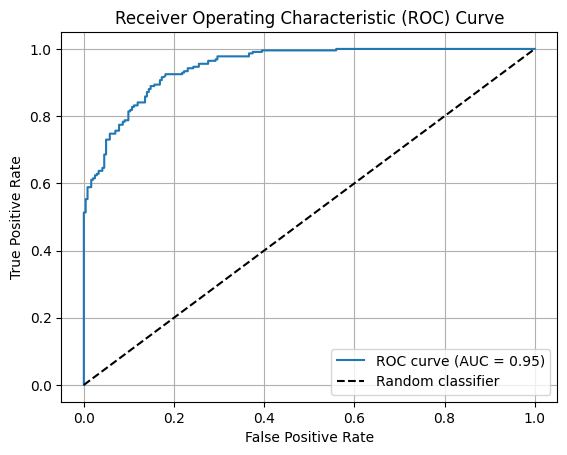

AUC: 0.95


In [32]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class (usually the second column in predict_proba output)
y_test_prob = test_prob[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Calculate the AUC
auc_score = roc_auc_score(y_test, y_test_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"AUC: {auc_score:.2f}")

# Decision tree

In [33]:
import textwrap
def next_steps(patient_profile, model, costs, thresholds, model_mrcp,model_eus,model_ercp):
    # Initial probability
    cumulative_cost=0
    initial_prob = model.predict_proba(patient_profile)[0][1]
    test_pr=[model_mrcp.predict_proba(patient_profile.to_numpy())[0][1]*100,model_eus.predict_proba(patient_profile.to_numpy())[0][1]*100,model_ercp.predict_proba(patient_profile.to_numpy())[0][1]*100]
    test_pr=np.round(test_pr,2)
    up_prob={'MRCP:':0,'EUS:':0,'ERCP:':0}
    
    mrcp_result = model_mrcp.predict(patient_profile.to_numpy())  # Simulated MRI result
    updated_prob = bayesian_update(initial_prob, sensitivity=0.63, specificity=0.999, result=mrcp_result)
    up_prob['MRCP:']=np.round(updated_prob*100,2)
    
    eus_result = model_eus.predict(patient_profile.to_numpy()) # Simulated EUS result
    updated_prob = bayesian_update(initial_prob, sensitivity=0.64, specificity=0.99, result=eus_result)
    up_prob["EUS:"]=np.round(updated_prob*100,2)

            
    ercp_result = model_ercp.predict(patient_profile.to_numpy())
    updated_prob = bayesian_update(initial_prob, sensitivity=0.87, specificity=0.99, result=ercp_result)
    up_prob['ERCP:']=np.round(updated_prob*100,2)

    # Step 1: Evaluate initial probability
    if initial_prob < thresholds[0]:
        cumulative_cost += costs['Surgery']
        msg=(f'The current probability of stone is {np.round(initial_prob,2)*100}%, the associated expected '
             f'cost with the surgery could be: {cumulative_cost}. The initial models predict {test_pr[0]}, '
             f'{test_pr[1]} and {test_pr[2]}% probability of detecting stone in MRCP, EUS and ERCP, respectively.')
        msg = textwrap.fill(msg, width=80)
        return msg,'Surgery',test_pr,up_prob
    elif initial_prob <= thresholds[1] and initial_prob >= thresholds[0]:
        cumulative_cost += costs['MRCP']
        msg=(f'The current probability of stone is {np.round(initial_prob,2)*100}%, the associated expected cost with the MRCP could be: {cumulative_cost}. The initial models predict {test_pr[0]}, {test_pr[1]} and {test_pr[2]}% probability of detecting stone in MRCP, EUS and ERCP, respectively.')
        msg = textwrap.fill(msg, width=80)
        return msg,'MRCP',test_pr,up_prob
    elif initial_prob <= thresholds[2] and initial_prob >= thresholds[1]:
        cumulative_cost += costs['EUS']
        msg=(f'The current probability of stone is {np.round(initial_prob,2)*100}%, the associated expected cost with the EUS could be: {cumulative_cost}. The initial models predict {test_pr[0]}, {test_pr[1]} and {test_pr[2]}% probability of detecting stone in MRCP, EUS and ERCP, respectively.')
        msg = textwrap.fill(msg, width=80)
        return msg,'EUS',test_pr,up_prob
    else:
        cumulative_cost += costs['ERCP']
        msg=(f'The current probability of stone is {np.round(initial_prob,2)*100}%, the associated expected cost with the ERCP could be: {cumulative_cost}. The initial models predict {test_pr[0]}, {test_pr[1]} and {test_pr[2]}% probability of detecting stone in MRCP, EUS and ERCP, respectively.')
        msg = textwrap.fill(msg, width=80)
        return msg,'ERCP',test_pr,up_prob


costs={'EUS':4368.7, 'ERCP':6769.2, 'Surgery':18895.3034, 'MRCP': 1000} #**** 


thresholds=[.25,.50,.75]
patient_profile=X_test.iloc[[12]]
print(next_steps(patient_profile, model, costs, thresholds, model_mrcp,model_eus,model_ercp)[0])


The current probability of stone is 69.0%, the associated expected cost with the
EUS could be: 4368.7. The initial models predict 23.45, 35.53 and 84.52%
probability of detecting stone in MRCP, EUS and ERCP, respectively.


In [36]:
thresholds=[.25,.50,.75]
mrcp_count=0
eus_count=0
ercp_count=0
surgery_count=0
missed_ercp_count=0
ioc_count=0
y_test2 = np.array(y_test)
for i in range(len(X_test)):
    
    patient_profile=X_test.iloc[[i]]
    tmp=next_steps(patient_profile, model, costs, thresholds, model_mrcp,model_eus,model_ercp)[1]
    predi_model=model.predict(patient_profile)
    if tmp=='MRCP':
        mrcp_count+=1
        # if y_test2[i]==0:
        #     missed_ercp_count+=1
    elif tmp=='EUS':
        eus_count+=1
        # if y_test2[i]==0:
        #     missed_ercp_count+=1
    elif tmp=='ERCP':
        ercp_count+=1
        # if y_test2[i]==0:
        #     missed_ercp_count+=1
    elif tmp=='Surgery':
        # if data.loc[i, 'Did intra-operative cholangiogram show a stone?']=='Yes':
        #     ioc_count=ioc_count+1
        if y_test2[i]==1:
            missed_ercp_count+=1
        #     print('missed_ercp_count',j,', ID=',data.loc[j, 'Record ID'])
        surgery_count+=1


# total_procedures = mrcp_count + eus_count + ercp_count + surgery_count
print(f'MRCP: {mrcp_count}, EUS: {eus_count}, ERCP: {ercp_count}, Surgery: {surgery_count}')
print(f'Total: {mrcp_count+eus_count+ercp_count+surgery_count}')
print('# Missed ERCP',(missed_ercp_count))
# print('# ppl with positive stone',sum(y_test2))
# print('# IOC:',ioc_count)

MRCP: 68, EUS: 58, ERCP: 168, Surgery: 175
Total: 469
# Missed ERCP 5


In [37]:
from graphviz import Digraph

def create_decision_tree():
    # Initialize the graph
    tree = Digraph(format='png')
    tree.attr('node', shape='box')

    # Top node
    tree.node('Start', 'Initial Probability')


    # Action nodes
    tree.node('A', '• Perform Surgery\n•(Cost: $18895.30)')
    tree.node('B', '• Prediction of stone in MRCP\n• Perform MRCP\n• (Cost: $1000)')
    tree.node('C', '• Prediction of stone in EUS\n• Perform EUS\n• (Cost: $4368.7)')
    tree.node('D', '• Prediction of stone in ERCP\n• Perform ERCP\n• (Cost: $6769.2)')


    # Define edges from the top box
    tree.edge('Start', 'A', 'Prob ≤ 25%')
    tree.edge('Start', 'B', '25% < Prob ≤ 50%')
    tree.edge('Start', 'C', '50% < Prob ≤ 75%')
    tree.edge('Start', 'D', 'Prob > 75%')

    return tree

# Generate and render the tree
decision_tree_v4 = create_decision_tree()
decision_tree_v4.render('DT', view=True)

'DT.png'